In [21]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential,load_model,Model
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
train_path = 'data/train'
test_path = 'data/test'
valid_path = 'data/valid'

In [24]:
train_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(train_path,target_size=(224,224),classes=['0','1','2','3','4','5'],batch_size=10) 
test_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(test_path,target_size= (224,224),classes=['0','1','2','3','4','5'],batch_size=5)
valid_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(valid_path,target_size=(224,224),classes=['0','1','2','3','4','5'],batch_size=10)
# train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['-1','0','1','2','3','4'],batch_size=10) 
# test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size= (224,224),classes=['-1','0','1','2','3','4'],batch_size=5)
# valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['-1','0','1','2','3','4'],batch_size=10)


Found 1200 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [18]:
def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 ==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],interpolation=None if interp else 'none')

In [19]:
imgs, labels =next(train_batches)

C:\Anaconda3\lib\site-packages\matplotlib\text.py:1190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


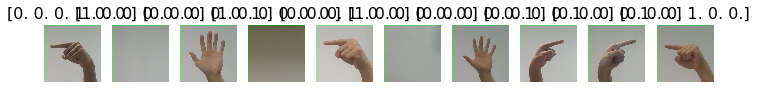

In [20]:
plots(imgs,titles=labels)

In [25]:
mobile = keras.applications.mobilenet.MobileNet()

In [26]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [27]:
x= mobile.layers[-6].output
predictions = Dense(6,activation='softmax')(x)

In [28]:
model = Model(inputs=mobile.input,outputs=predictions)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [30]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [32]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit_generator(train_batches, steps_per_epoch=22,validation_data=valid_batches,validation_steps=4,epochs=4,verbose=1)

Epoch 1/4
22/22 [==============================] - 107s 5s/step - loss: 0.7502 - acc: 0.7773 - val_loss: 1.6687 - val_acc: 0.4750
Epoch 2/4
22/22 [==============================] - 101s 5s/step - loss: 0.0995 - acc: 0.9773 - val_loss: 1.0283 - val_acc: 0.6250
Epoch 3/4
22/22 [==============================] - 102s 5s/step - loss: 0.0367 - acc: 1.0000 - val_loss: 0.7931 - val_acc: 0.6750
Epoch 4/4
22/22 [==============================] - 101s 5s/step - loss: 0.0315 - acc: 0.9955 - val_loss: 0.5541 - val_acc: 0.8500


In [34]:
model.save('mobile_net_model_v2_0-5.h5')

In [35]:
test_imgs,test_labels = next(test_batches)
test_labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [36]:
predictions = model.predict(test_imgs)
predictions

array([[1.7291944e-03, 8.6463895e-03, 7.5096816e-01, 1.8653613e-01,
        6.2815845e-03, 4.5838587e-02],
       [3.7500719e-03, 4.4634381e-01, 1.4015207e-02, 2.7709427e-01,
        1.0169696e-01, 1.5709957e-01],
       [2.4357361e-04, 7.1739737e-04, 2.5514979e-03, 3.7331486e-03,
        9.8814791e-01, 4.6064528e-03],
       [1.2260924e-04, 6.4574979e-04, 1.9310594e-02, 9.7216189e-01,
        9.3921152e-04, 6.8199639e-03],
       [4.8696420e-01, 1.8654093e-02, 1.2064379e-01, 1.5871014e-01,
        2.3399660e-02, 1.9162811e-01]], dtype=float32)

# Try load the model

In [ ]:
from keras.utils.generic_utils import CustomObjectScope
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    Model = load_model('mobile_net_model.h5')